# NLP Group Project
### Alberto Puentes, Parker Voit, Tyler Applegate
#### Florence Cohort, 2021_08_03

In [1]:
# general imports
import requests
from requests import get
from bs4 import BeautifulSoup
import os
import re
import numpy as np
import pandas as pd
import markdown 
import nltk
import csv

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator

# our function modules
import acquire
import prepare
import explore

# imports for modeling
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score, plot_confusion_matrix

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

## Project Overview

## Key Findings:
- We found that our [**model**] outperformed all other models, including the baseline. 
- This model achieved [**percent**] overall accuracy on our training data, [**percent**] on our validate set, and finally [**percent**] on the unseen test data set.
- With more time, we would like to explore [**Hawaii, Portugal, and New Zealand**]

## Data Acquisition

In [2]:
# use our function to pull in raw data
repo_df = acquire.get_github_data(cached = True)

In [3]:
acquire.overview(repo_df)

This dataframe has 120 rows and 3 columns.
----------------------------------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120 entries, 0 to 119
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             120 non-null    object
 1   language         120 non-null    object
 2   readme_contents  119 non-null    object
dtypes: object(3)
memory usage: 3.8+ KB
None
----------------------------------

Unique value counts of each column

repo               120
language             4
readme_contents    119
dtype: int64
----------------------------------

Stats on Numeric Columns

                     repo    language  \
count                 120         120   
unique                120           4   
top     /wubaiqing/zaobao  JavaScript   
freq                    1          30   

                                          readme_contents  
count                                                 119  
uniqu

### Data Acquisition - Key Findings & Takeaways:
- We are looking at 120 observations, evenly distributed across 4 programming languages
- There appears to be 1 null value
- There are also multiple files that are in foreign languages
- For our first iteration, we are going to drop the null value, and foreign language repos

## Data Preparation

In [4]:
# perform our inital data prep and look at key stats
df = prepare.prep_article_data(repo_df, 'readme_contents', tokenizer=prepare.tokenize, extra_words = ['fr','freesvghttpsgithubcomlisadziubaawesomedesigntoolsblobmastermediafreesvg','opensourcesvghttpsgithubcomlisadziubaawesomedesigntoolsblobmastermediaopensourcesvg'])
acquire.overview(df)

This dataframe has 102 rows and 6 columns.
----------------------------------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102 entries, 0 to 119
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   repo                        102 non-null    object
 1   language                    102 non-null    object
 2   readme_contents             102 non-null    object
 3   cleaned_readme_contents     102 non-null    object
 4   stemmed_readme_contents     102 non-null    object
 5   lemmatized_readme_contents  102 non-null    object
dtypes: object(6)
memory usage: 5.6+ KB
None
----------------------------------

Unique value counts of each column

repo                          102
language                        4
readme_contents               102
cleaned_readme_contents       102
stemmed_readme_contents       102
lemmatized_readme_contents    102
dtype: int64
----------------------------------


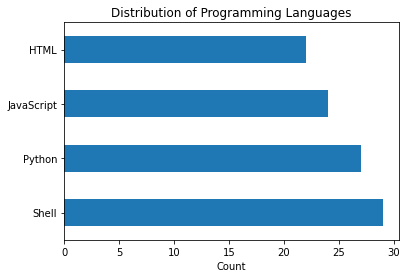

In [5]:
# visualize distribution of target variable

df.language.value_counts().plot.barh()
plt.title('Distribution of Programming Languages')
plt.xlabel("Count")
plt.show()

In [6]:
# split our data prior to exploration, stratifying on target variable 'language'
train, validate, test = prepare.train_validate_test_split(df, 'language')

In [7]:
# what does our training set look like?
acquire.overview(train)

This dataframe has 56 rows and 6 columns.
----------------------------------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56 entries, 86 to 3
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   repo                        56 non-null     object
 1   language                    56 non-null     object
 2   readme_contents             56 non-null     object
 3   cleaned_readme_contents     56 non-null     object
 4   stemmed_readme_contents     56 non-null     object
 5   lemmatized_readme_contents  56 non-null     object
dtypes: object(6)
memory usage: 3.1+ KB
None
----------------------------------

Unique value counts of each column

repo                          56
language                       4
readme_contents               56
cleaned_readme_contents       56
stemmed_readme_contents       56
lemmatized_readme_contents    56
dtype: int64
----------------------------------

Stats on

In [8]:
df

,repo,language,readme_contents,cleaned_readme_contents,stemmed_readme_contents,lemmatized_readme_contents
0,/awesome-selfhosted/awesome-selfhosted,JavaScript,# Awesome-Selfhosted\n\n[![Awesome](https://cd...,awesomeselfhosted selfhosting practice locally...,awesomeselfhost selfhost practic local host ma...,awesomeselfhosted selfhosting practice locally...
2,/goabstract/Awesome-Design-Tools,JavaScript,"<div class=""hidden-in-page"">\n\n# Awesome Desi...",awesome design tools awesome design pluginshtt...,awesom design tool awesom design pluginshttpsg...,awesome design tool awesome design pluginshttp...
3,/viatsko/awesome-vscode,JavaScript,"\n<br/>\n<div align=""center"">\n <img width=""3...",curated list delightful visual studio codehttp...,curat list delight visual studio codehttpscode...,curated list delightful visual studio codehttp...
5,/davidsonfellipe/awesome-wpo,JavaScript,# Awesome WPO [![Awesome](https://cdn.rawgit.c...,awesome wpo curated list web performance optim...,awesom wpo curat list web perform optim everyo...,awesome wpo curated list web performance optim...
6,/shekhargulati/52-technologies-in-2016,JavaScript,\n52 technologies in 2016 [![GitHub Stats](htt...,52 technologies 2016 taken challenge learn new...,52 technolog 2016 taken challeng learn new tec...,52 technology 2016 taken challenge learn new t...
...,...,...,...,...,...,...
115,/buren/awesome-sweden,Shell,# Sweden [![awesome](https://awesome.re/badge-...,sweden list curated list awesome things use co...,sweden list curat list awesom thing use code s...,sweden list curated list awesome thing use cod...
116,/jeffreytse/jekyll-deploy-action,Shell,"<div align=""center"">\n <br>\n\n <a href=""htt...",github action deploy jekyll site conveniently ...,github action deploy jekyl site conveni github...,github action deploy jekyll site conveniently ...
117,/tajmone/awesome-interactive-fiction,Shell,= Awesome Interactive Fiction link:https://awe...,awesome interactive fiction linkhttpsawesomere...,awesom interact fiction linkhttpsawesomereimag...,awesome interactive fiction linkhttpsawesomere...
118,/stve/awesome-dropwizard,Shell,# Awesome Dropwizard [![Awesome](https://cdn.r...,awesome dropwizard useful resources creating a...,awesom dropwizard use resourc creat app dropwi...,awesome dropwizard useful resource creating ap...


### Data Preparation - Key Findings & Takeaways:

## Data Exploration

In [20]:
# create lists of all words, java words, html words, python words, and shell words

all_words = (' '.join(train.cleaned_readme_contents))
java_words = (' '.join(train[train.language == 'JavaScript'].cleaned_readme_contents))
shell_words = (' '.join(train[train.language == 'Shell'].cleaned_readme_contents))
python_words = (' '.join(train[train.language == 'Python'].cleaned_readme_contents))
html_words = (' '.join(train[train.language == 'HTML'].cleaned_readme_contents))

In [21]:
# convert the lists to number counts of each word

all_freq = pd.Series(all_words.split()).value_counts()
java_freq = pd.Series(java_words.split()).value_counts()
shell_freq = pd.Series(shell_words.split()).value_counts()
python_freq = pd.Series(python_words.split()).value_counts()
html_freq = pd.Series(html_words.split()).value_counts()

In [22]:
df = pd.concat([java_freq, shell_freq, python_freq, html_freq, all_freq], axis=1).fillna(0).astype(int)
df.columns = ['java', 'shell', 'python', 'html', 'all']
df.head()

,java,shell,python,html,all
covid19,280,3,0,1,284
code,256,214,136,64,670
design,225,120,28,48,421
coronavirus,164,0,0,0,164
free,162,203,19,24,408


In [23]:
this_list = [all_words, java_words, shell_words, python_words, html_words]
that_list = ['all_words', 'java_words', 'shell_words', 'python_words', 'html_words']

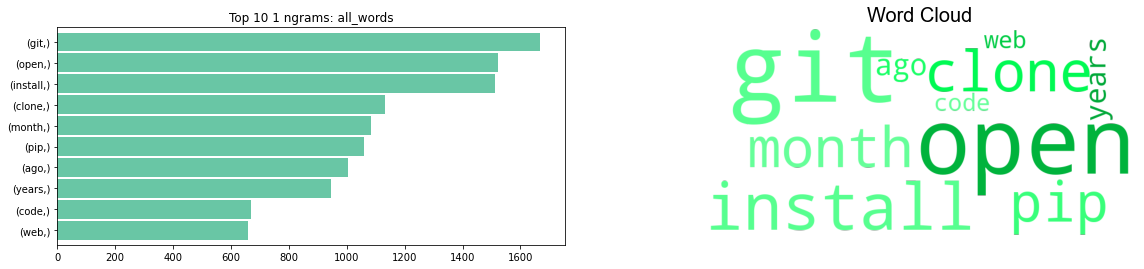

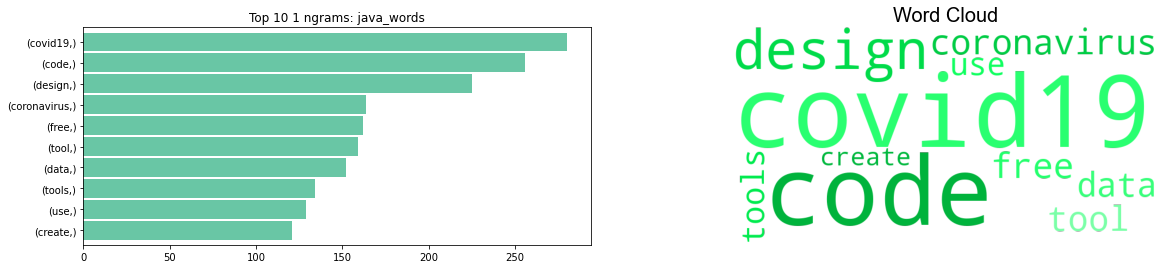

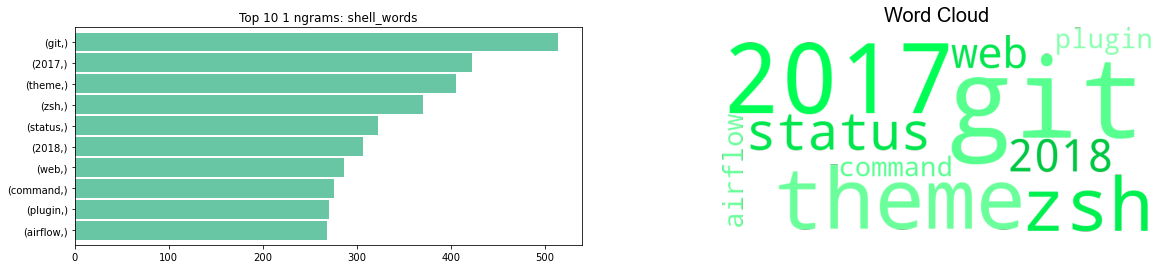

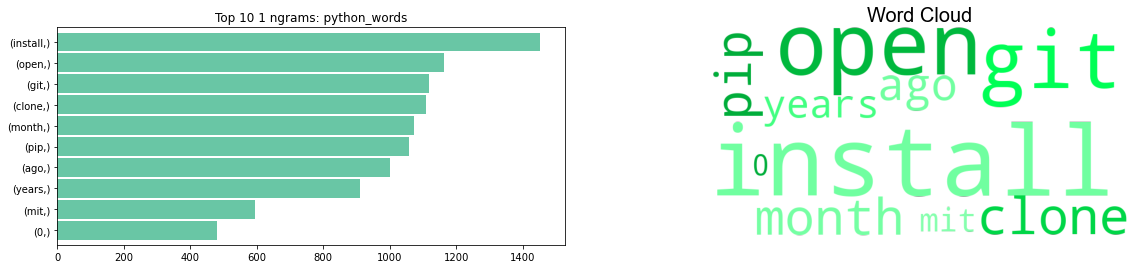

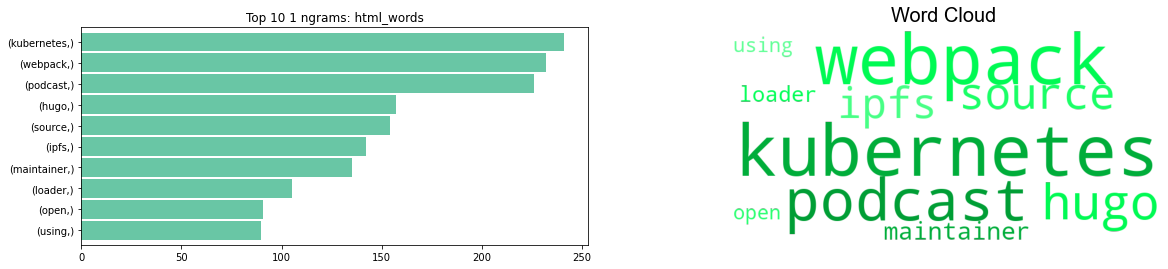

In [25]:
# let's look at the top 10 words for each language
explore.word_count_word_cloud(this_list, that_list)

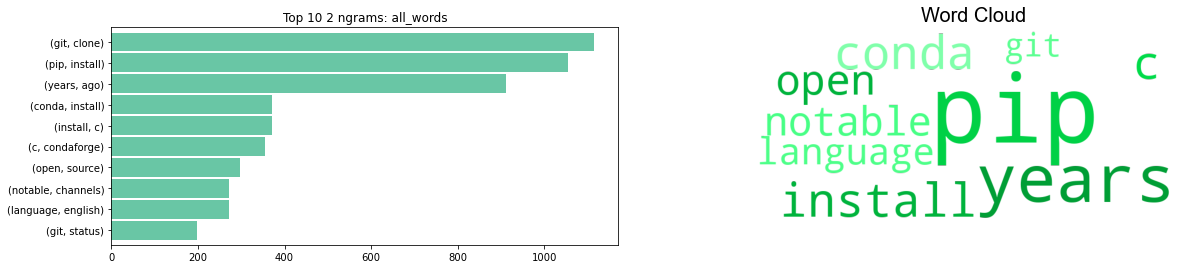

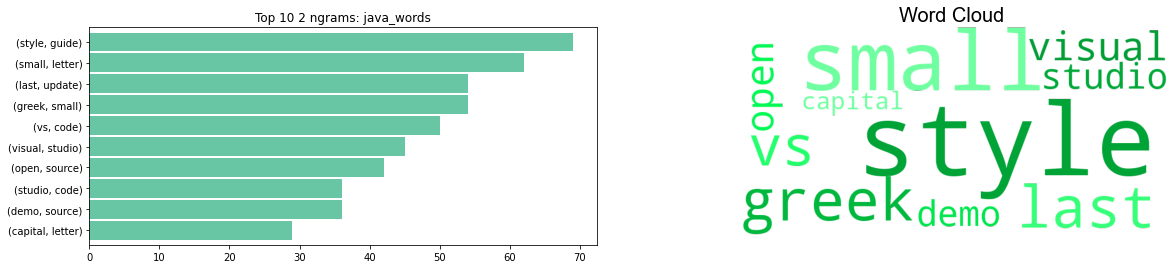

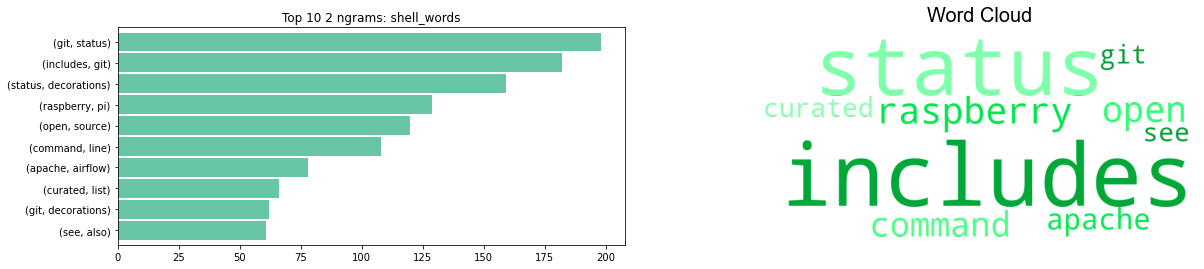

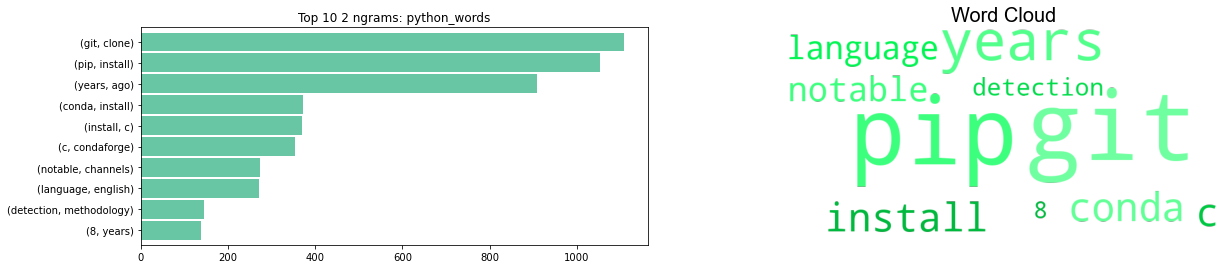

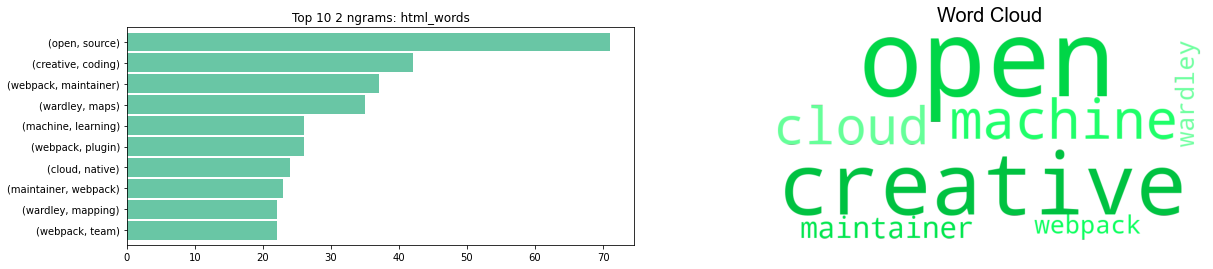

In [26]:
# now let's look at bigrams
explore.word_count_word_cloud(this_list, that_list, n = 2, x=10, title_name = None)

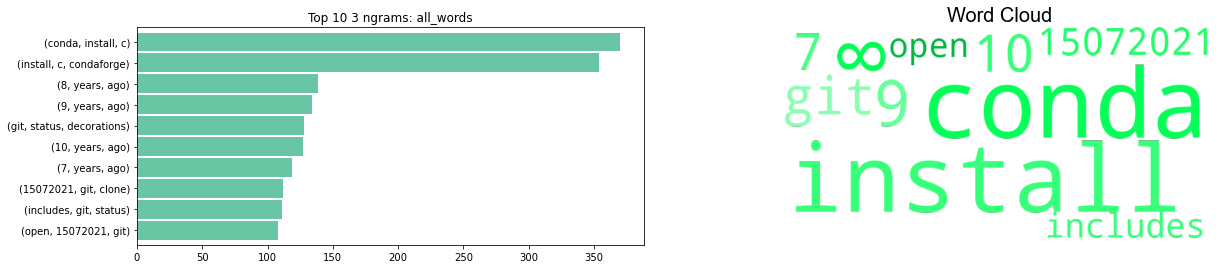

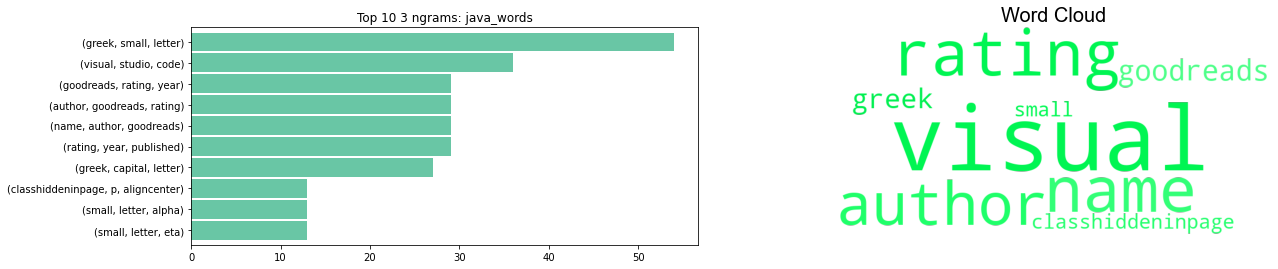

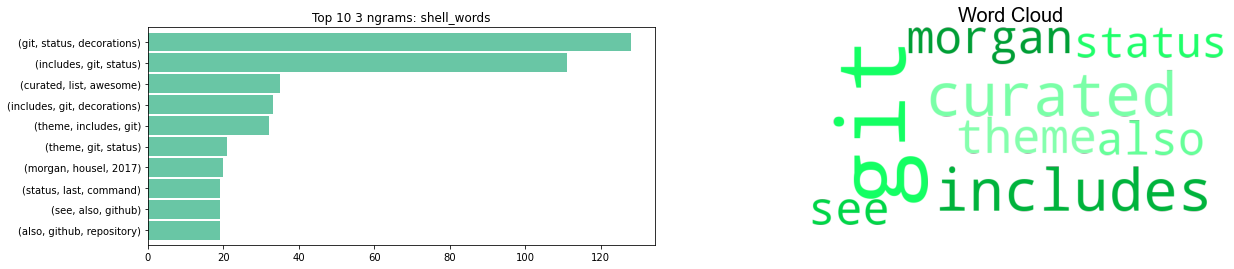

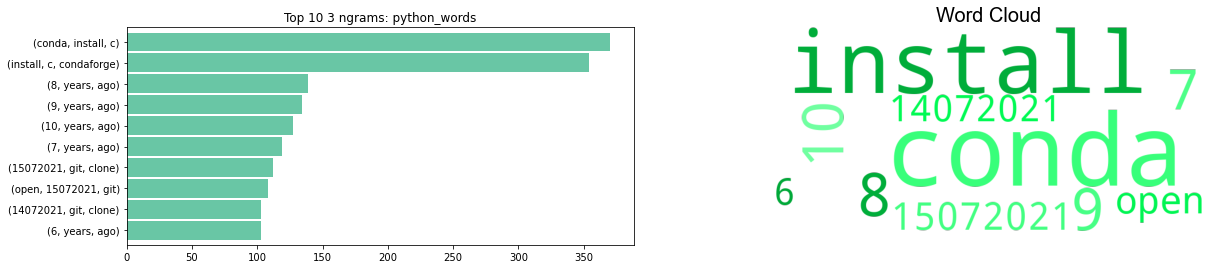

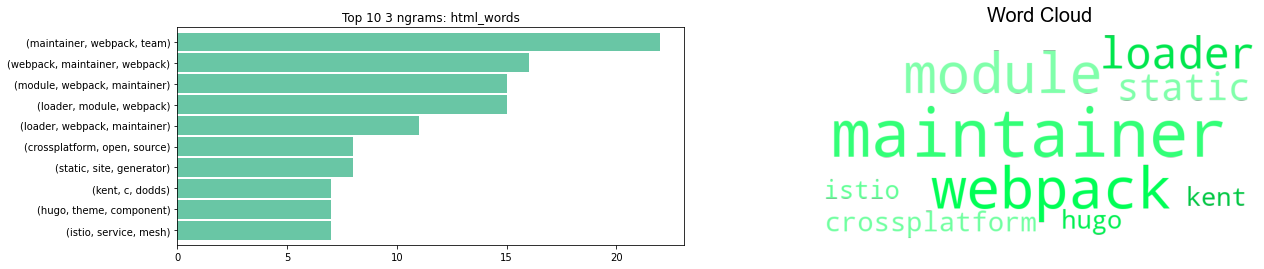

In [27]:
# and finally, let's see trigrams...
explore.word_count_word_cloud(this_list, that_list, n = 3, x=10, title_name = None)

In [29]:
train['length'] = [len(i) for i in train.cleaned_readme_contents]
train.groupby(by = 'language').mean().round(0)

,length
language,
HTML,13579.0
JavaScript,25123.0
Python,42318.0
Shell,36810.0


Length Takeaways:
- Python has the largest average character count 
- JavaScript and Shell have somewhat equal character counts
- HTML has the least amount

### Data Exploration - Key Findings & Takeaways:

## Model Building

### Model Building - Key Findings & Takeaways:

## Model Evaluation

### Model Evaluation - Key Findings & Takeaways:

## Final Conclusions & Next Steps